## COMP5625M Assessment 1 - Image Classification [100 marks]

<div class="logos"><img src="https://drive.google.com/uc?id=132BXgkV5w1bpXlVpdr5BtZdpagqYvna7" width="220px" align="right"></div>

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will gain practical experience in:

> 1. Implementing and evaluating a multi-layer perceptron (MLP) and convolutional neural network (CNN) in solving a classification problem
> 2. Building, evaluating, and finetuning a CNN on an image dataset from development to testing 
> 3. Tackling overfitting using strategies such as data augmentation and drop out
> 4. Fine tuning a model 
> 5. Comparing the performance of a new model with an off-the-shelf model (AlexNet)
> 6. Gaining a deeper understanding of model performance using visualisations from Grad-CAM.


### Setup and resources 

You must work using this template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU. We highly recommend you use platforms such as Colab.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from a direct link or the Kaggle challenge website:

>[Direct access to data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[Access data through Kaggle webpage](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


### Required submissions

##### 1. Kaggle Competition
To participate in the submission of test results, you will need an account. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. [Link to submit your results on Kaggle competition](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/submissions). 

Please submit only your predictions from test set - detailed instructions are provided in (3)

##### 2. Submission of your work

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected images from section 6 "Failure/success analysis" (outputs from gradcam, for example you can put these images into failure and succcess folders).

**Final note:**

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.



Your student username (for example, ```sc15jb```):

sc21xz

Your full name:

Zhiping Xiang

## Required packages

[1] [numpy](http://www.numpy.org) is a package for scientific computing with python

[2] [h5py](http://www.h5py.org) is a package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is a library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed - examples of importing libraries are provided below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [61]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

In [62]:
# always check your version
print(torch.__version__)
import torch
import math
torch.device('mps')
print(torch.backends.mps.is_available())
# True
print(torch.backends.mps.is_built())
# True
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('mps' if torch.backends.mps.is_available() else 'cpu')

1.13.1
True
True
mps


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**

**1. Function implementation** (12 marks)

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (4 marks)

**2. Model training** (20 marks)
*   **2.1** Train on TinyImageNet30 dataset (7 marks)
*   **2.2** Generate confusion matrices and ROC curves (4 marks)
*   **2.3** Strategies for tackling overfitting (9 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset** (20 marks)
*   **3.1** Fine-tune your model (initialise your model with pretrained weights from (2)) (8 marks)
*   **3.2** Fine-tune model with frozen base convolution layers (8 marks)
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe? (4 marks) 

**4. Model testing** (18 marks)
*   **4.1**   Test your final model in (2) on test set - code to do this (10 marks)
*   **4.2**   Upload your result to Kaggle  (8 marks)

**5. Model comparison** (14 marks)
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (6 marks)
*   **5.2**   Compare the results of your CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks)

**6. Interpretation of results** (16 marks)
*   **6.1** Use grad-CAM on your model and on AlexNet (6 marks)
*   **6.2** Visualise and compare the results from your model and from AlexNet (4 marks)
*   **6.3** Comment on (6 marks):
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

## 1 Function implementations [12 marks]


### 1.1 Dataset class [4 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [123]:
# Imports
import os
from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms

# Define your own class LoadFromFolder
class TinyImageNet30Dataset(Dataset):
    def __init__(self, root_dir,classes,transform=None):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.classes = classes
        self.transform=transform

        # Iterate over all classes
        for i, c in enumerate(classes):
            class_dir = os.path.join(root_dir, c)
            # print(i,c)
            if os.path.isdir(class_dir):
                # Add all images in this class directory to the dataset
                for image_name in os.listdir(class_dir):
                    image_path = os.path.join(class_dir, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(i)
        print(len(self.image_paths))


    def __len__(self):
        # Return the previously computed number of images
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]

        with Image.open(image_path) as img:
            img = img.convert('RGB')
            # Apply transform
            img_tensor = self.transform(img)
            # Retrieve the label for this image
            label = self.labels[index]
            # Convert label to tensor
            label_tensor = torch.tensor(label, dtype=torch.long)

        return img_tensor, label_tensor


In [125]:
from torch.utils.data import DataLoader
# load the dataset
train_set_root='./comp5623m-artificial-intelligence/train_set/train_set/train_set'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

 # load the classes
file = open("./comp5623m-artificial-intelligence/class.txt", "r")
contents=[]
for line in file.readlines():
    curLine=line.strip().split("\t")
    contents.append(curLine[:])
classes=[items[1] for items in contents]
# print('classes:',classes)

batch_size=64
dataset = TinyImageNet30Dataset(root_dir=train_set_root,classes=classes, transform=transform)
dataloader = DataLoader(dataset,batch_size=batch_size)


# Get a single batch of data
images, labels = next(iter(dataloader))
print(next(iter(images)).shape)  # prints shape of image with single batch



13500
torch.Size([3, 64, 64])


### 1.2 Define a MLP model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [65]:
# TO COMPLETE
# define a MLP Model class
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Define the input, hidden, and output sizes
input_size = 3*64*64 #(channel* height * width)
hidden_size =128
output_size = 30 # 30 classes

# Create the MLP model
model_MLP = MLP(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
loss_function_MLP = nn.CrossEntropyLoss()
optimizer_MLP = optim.SGD(model_MLP.parameters(), lr=0.01)

### 1.3 Define a CNN model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [95]:
class CNN(nn.Module):
    def __init__(self, num_classes=30):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4=nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512)
        )
        self.reLu1=nn.ReLU()
        self.fc1 = nn.Linear(512, 1024)
        self.reLu2=nn.ReLU()

        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out=self.layer4(out)
        out=self.reLu1(out)
        out = self.fc1(out)
        out=self.reLu2(out)
        out = self.fc2(out)

        return out

num_classes=30
learning_rate=0.001
# Set up the model, loss function, and optimizer
model_CNN = CNN(num_classes=30).to(device)
loss_function_CNN = nn.CrossEntropyLoss()
optimizer_CNN = optim.SGD(model_CNN.parameters(), lr=learning_rate,momentum=0.9)

## 2 Model training [20 marks]


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side [7 marks]

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [86]:
from torch.utils.data import random_split

# Set seed for reproducibility
torch.manual_seed(0)

# Split the dataset into train and validation sets
test_ratio=0.2


# Split the dataset into training and validation sets
val_size = int(test_ratio * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False)


# Get a single batch of data
images, labels = next(iter(train_dataloader))
print('train_dataloader completed:',next(iter(images)).shape)  # prints shape of image with single batch

# Get a single batch of data
images, labels = next(iter(val_dataloader))
print('val_dataloader completed:',next(iter(images)).shape)  # prints shape of image with single batch


train_dataloader completed: torch.Size([3, 64, 64])
val_dataloader completed: torch.Size([3, 64, 64])


In [68]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [96]:
#TO COMPLETE --> Running you MLP model class
epochs = 30

# Lists to keep track of training/validation loss and accuracy over epochs
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
best_val_acc = 0.0
 # Train model
for epoch in range(epochs):
    # Training
    train_loss = 0
    train_acc = 0
    model_MLP.train()
    for images, labels in train_dataloader:
        images = images.view(images.size(0), -1).to(device)# Flatten input images
        labels=labels.to(device)
        optimizer_MLP.zero_grad()
        outputs = model_MLP(images)
        loss = loss_function_MLP(outputs, labels)
        loss.backward()
        optimizer_MLP.step()
        train_loss += loss.item()
        acc = topk_accuracy(outputs, labels, topk=(1,))[0]
        train_acc += acc.item()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    val_loss = 0
    val_acc = 0
    model_MLP.eval()
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.view(images.size(0), -1).to(device)# Flatten input images
            labels=labels.to(device)
            outputs = model_MLP(images)
            loss = loss_function_MLP(outputs, labels)
            val_loss += loss.item()
            acc = topk_accuracy(outputs, labels, topk=(1,))[0]
            val_acc += acc.item()
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

    # Save the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_MLP.state_dict(), 'best_model_mlp.pth')

# Print loss and accuracy values for current epoch
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


KeyboardInterrupt: 

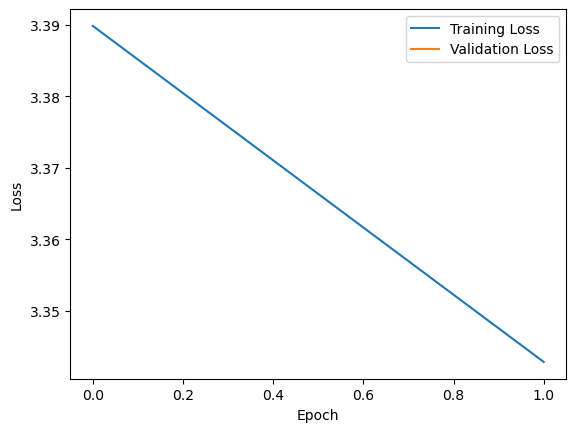

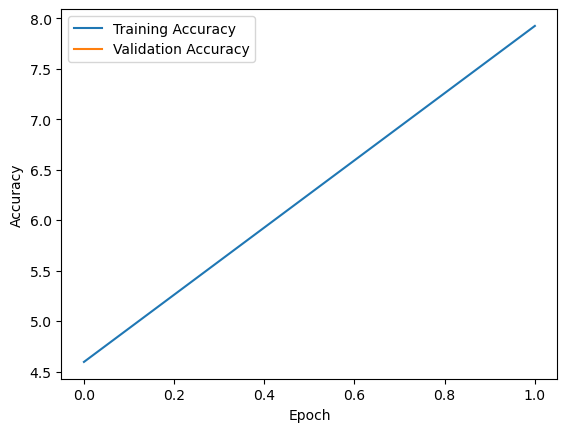

In [70]:
# Your graph

# Plot loss and accuracy values over epochs
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [97]:
#TO COMPLETE --> Running you CNN model class
epochs = 30

# Lists to keep track of training/validation loss and accuracy over epochs
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
best_val_acc = 0.0

 # Train model
for epoch in range(epochs):
    # Training
    train_loss = 0
    train_acc = 0
    model_CNN.train()
    for images, labels in train_dataloader:
        images = images.to(device)# Flatten input images
        labels=labels.to(device)
        optimizer_CNN.zero_grad()
        outputs = model_CNN(images)
        loss = loss_function_CNN(outputs, labels)
        loss.backward()
        optimizer_CNN.step()
        train_loss += loss.item()
        acc = topk_accuracy(outputs, labels, topk=(1,))[0]
        train_acc += acc.item()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    val_loss = 0
    val_acc = 0
    model_CNN.eval()
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)# Flatten input images
            labels=labels.to(device)
            outputs = model_CNN(images)
            loss = loss_function_CNN(outputs, labels)
            val_loss += loss.item()
            acc = topk_accuracy(outputs, labels, topk=(1,))[0]
            val_acc += acc.item()
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

 # Save the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        temp=best_val_acc
        best_val_acc = val_acc
        if train_acc>99.5 and best_val_acc>50.5:
            torch.save(model_CNN.state_dict(), 'best_model_cnn.pth')
            break

# Print loss and accuracy values for current epoch
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


Epoch [1/30], Train Loss: 3.1017, Train Acc: 14.76%, Val Loss: 2.7427, Val Acc: 21.45%
Epoch [2/30], Train Loss: 2.5114, Train Acc: 28.69%, Val Loss: 2.3785, Val Acc: 32.10%
Epoch [3/30], Train Loss: 2.2014, Train Acc: 37.19%, Val Loss: 2.2413, Val Acc: 35.91%
Epoch [4/30], Train Loss: 1.9594, Train Acc: 43.80%, Val Loss: 2.2563, Val Acc: 36.16%
Epoch [5/30], Train Loss: 1.7653, Train Acc: 48.59%, Val Loss: 2.0851, Val Acc: 39.95%
Epoch [6/30], Train Loss: 1.5902, Train Acc: 54.29%, Val Loss: 2.0464, Val Acc: 42.01%
Epoch [7/30], Train Loss: 1.4288, Train Acc: 58.22%, Val Loss: 1.8852, Val Acc: 45.99%
Epoch [8/30], Train Loss: 1.2845, Train Acc: 62.49%, Val Loss: 1.8471, Val Acc: 46.88%
Epoch [9/30], Train Loss: 1.1511, Train Acc: 66.27%, Val Loss: 1.9208, Val Acc: 46.77%
Epoch [10/30], Train Loss: 0.9813, Train Acc: 72.14%, Val Loss: 2.2830, Val Acc: 40.69%
Epoch [11/30], Train Loss: 0.8661, Train Acc: 75.04%, Val Loss: 1.9850, Val Acc: 46.72%
Epoch [12/30], Train Loss: 0.7177, Train 

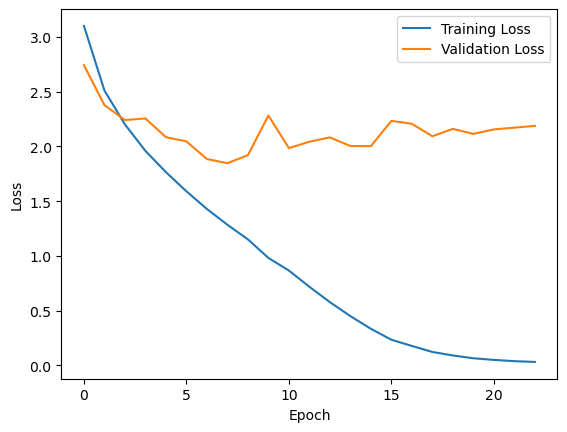

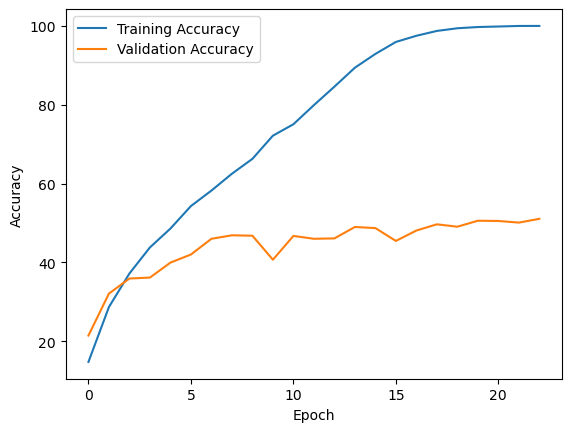

In [98]:
# Your graph

# Plot loss and accuracy values over epochs
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

### 2.2 Generating confusion matrix and ROC curves [4 marks]
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

<class '__main__.CNN'>
get predictions for the training set successfully!
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([64, 30])
torch.Size([12, 30])
get predictions and pro

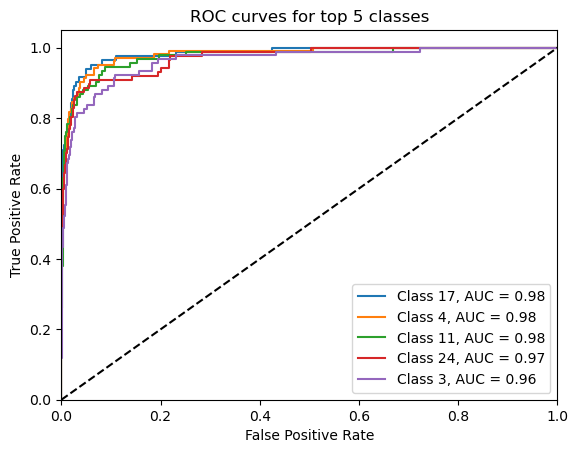

In [119]:
# Your code here!
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load the model

# Load the trained model
# Load the saved model
model=model_CNN
model.load_state_dict(torch.load('best_model_cnn.pth'))
print(type(model))

model.eval()


# Create lists to store predictions and labels
train_preds = []
train_labels = []
val_preds = []
val_labels = []
# Create empty lists for true labels and predicted probabilities:
val_labels_roc = []
val_probs = []


# Evaluate the model on the training set
for inputs, labels in train_dataloader:
    with torch.no_grad():
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Append predictions and labels to lists
        train_preds.extend(preds.tolist())
        train_labels.extend(labels.tolist())

print('get predictions for the training set successfully!')

# Evaluate the model on the validation set
for inputs, labels in val_dataloader:
    inputs=inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Append predictions and labels to lists
        val_preds.extend(preds.tolist())
        val_labels.extend(labels.tolist())
        # append to roc
        probs = torch.nn.functional.softmax(outputs, dim=1)
        # print(probs.size()) # check the size of probs
        val_labels_roc.append(labels.cpu().numpy())
        val_probs.append(probs.cpu().numpy())

print('get predictions and probabilities for the validation set successfully!')

# Compute the confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)

# Normalize the confusion matrices
train_cm_norm = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]
val_cm_norm = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrices
print("Training Set Confusion Matrix:")
print(train_cm_norm)
print("Validation Set Confusion Matrix:")
print(val_cm_norm)


# ROC
# Concatenate the true labels and predicted probabilities into numpy arrays
print(len(val_probs))
val_labels_roc = np.concatenate(val_labels_roc)
val_probs = np.concatenate(val_probs)

# Compute the ROC curves and AUCs for each class using scikit-learn:

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(val_labels) == i, val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# sort top 5
top_classes = sorted(range(num_classes), key=lambda i: roc_auc[i], reverse=True)[:5]
# plt

plt.figure()

for i in top_classes:
    plt.plot(fpr[i], tpr[i], label='Class {}, AUC = {:.2f}'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for top 5 classes')
plt.legend(loc="lower right")
plt.show()


**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting (9 marks)
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


In [ ]:
# Your code here!

#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

In [ ]:
# Your code here!

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

In [ ]:
# Your code here!

In [ ]:
# Your graph

### 3 Model testing [18 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions [10 marks]

> Build a test class, prepare a test dataloader and generate predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [126]:
# Your code here!
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

# Load the test dataset
test_set_root='./comp5623m-artificial-intelligence/test_set/test_set'
test_dataset = datasets.ImageFolder(test_set_root, transform=transform)

# Define the dataloader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get a single batch of data
images, labels = next(iter(test_dataloader))
print(next(iter(images)).shape)  # prints shape of image with single batch


# do predicitions

# Load the saved model
model=model_CNN
model.load_state_dict(torch.load('best_model_cnn.pth'))
print(type(model))

# Make predictions on the test dataset
results = []
for inputs, _ in test_dataloader:
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    results.extend(predicted.cpu().numpy())


# Save the results to a CSV file
filenames = [path.split('/')[-1] for path, _ in test_dataset.imgs]
df = pd.DataFrame({'filename': filenames, 'class': results})
df.to_csv('test_results.csv', index=False)



FileNotFoundError: Couldn't find any class folder in ./comp5623m-artificial-intelligence/test_set/test_set/test_set.

#### 3.2 Prepare your submission and upload to Kaggle [8 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [8 marks]. The class leaderboard will not affect marking (brownie points!).


In [ ]:
# Your code here! 


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [20 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [ ]:
# Your code here! 

> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [ ]:
# Your code here! 

#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>


> Configuration 1: No frozen layers

In [ ]:
# Your model changes here - also print trainable parameters

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [ ]:
# Your changes here - also print trainable parameters

#### 4.3 Compare above configurations and comment on comparative performance

In [ ]:
# Your graphs here and please provide comment in markdown in another cell

### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [ ]:
# Your code here! 

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


In [ ]:
# Your code here! 

### 6 Interpretation of results (16 marks)

> Please use TinyImageNet30 dataset for all results


#### 6.1-6.2 Implement grad-CAM and visualise results (10 marks)

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [ ]:
# Your code here!

In [ ]:
# Your code here!

In [ ]:
# Your code here!

#### 6.3 Your comments on (6 marks):
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> b) What can you do to improve your results further?

---> Double click to respond here

**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
